## Accelerating Metal-Organic Framework Discovery via Synthesisability Prediction: The MFD Evaluation Method for One-Class Classification Models

Chi Zhang, Dmytro Antypov, Matthew J. Rosseinsky, and Matthew S. Dyer*<br/>
Email: M.S.Dyer@liverpool.ac.uk <br/>

Please cite the corresponding paper if you use the Maximum Fractional Difference (MFD) method or these trained machine learning (ML) models in your work.<br/>

The Jupyter Notebook hereafter presents the score and the positive fraction distributions for the poor model used for comparison: the IForest model trained by 6 elemental metal features and 1613-dimensional linker features from Mordred, with an MFD value of 0.08.(corresponding to Figure 5(c)) It also shows the creation of the positive validation dataset and model validation procedure.(corresponding to Figure 5(a)).

This notebook requires the following input files:

`IForest_train.csv` - the prediction results of the IForest model for the ground_truth dataset<br/>
`IForest_test.csv` - the prediction results of the IForest model for the query dataset<br/>

This notebook requires the following input files from the `dataset_generation_and_featurization` folder:

`ground_truth_pairs.csv` - the list of metal and linker combinations of the ground_truth dataset<br/>
`query_pairs.csv` - the list of metal and linker combinations of the query dataset<br/>
`linker_list.pkl` - the list of linkers<br/>
`metal_scaled_6.csv` - the list of normalised 6 metal features<br/>
`linker_scaled_1613.csv` - the list of normalised 1613 mordred linker features<br/>

This notebook outputs the following files:

`poor_train.csv` - the prediction results of the IForest model for the training dataset<br/>
`poor_test.csv` - the prediction results of the IForest model for the query dataset<br/>
`poor_val.csv` - the prediction results of the IForest model for the validation dataset<br/>

This folder also includes the following file(s):

`deep_model.tar` - the saved best-performing DeepSVDD model<br/>
`clf_iforest.joblib` - the saved poor IForest model

### Import library and labelled dataset

In [2]:
#import libraries
import pandas as pd
import numpy as np

#from sklearn.preprocessing import scaler Methods
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn import datasets, metrics
from numpy import nan as NaN

# model

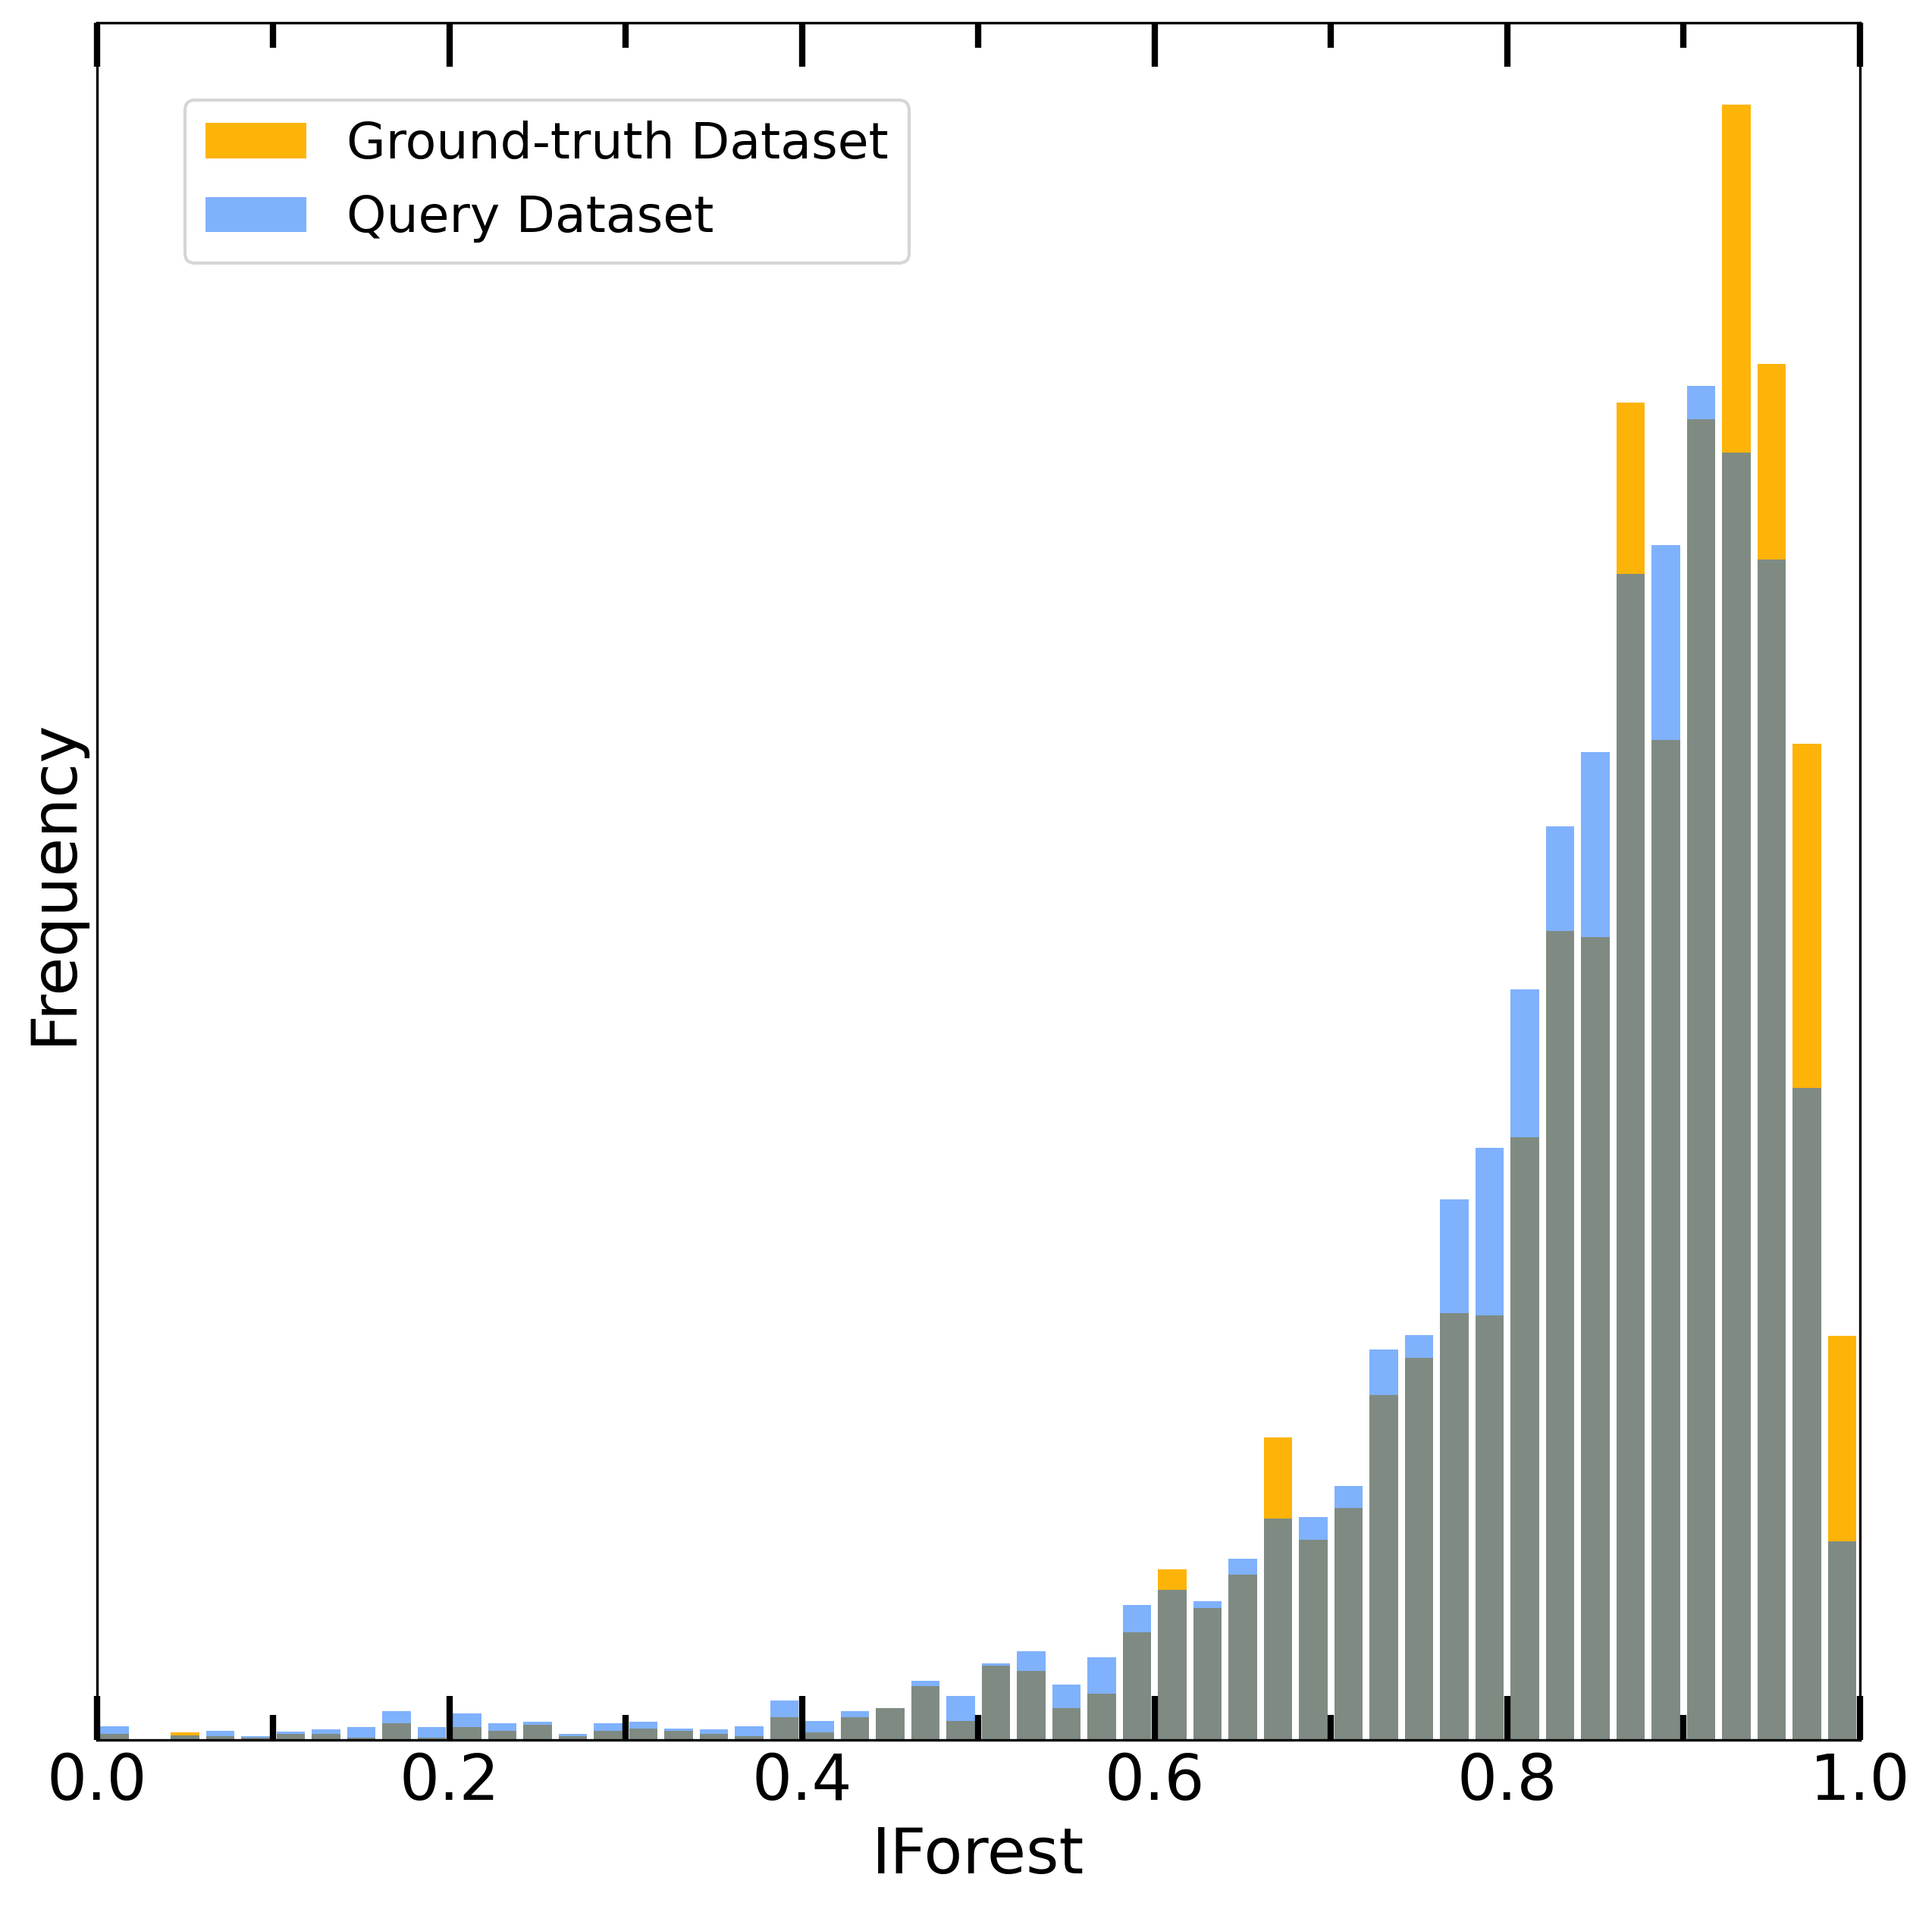

In [8]:
#import results
train_result = pd.read_csv('IForest_train.csv', index_col=0)
test_result = pd.read_csv('IForest_test.csv', index_col=0)

MinMax_scaler = preprocessing.MinMaxScaler()

#plot score distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

#score normalisation
scores_range = np.concatenate((train_result.iloc[:,0],test_result.iloc[:,0])).reshape(-1,1)
scores_scaler = MinMax_scaler.fit(scores_range)
train_scores = scores_scaler.transform(np.array(train_result.iloc[:,0]).reshape(-1,1)) 
test_scores = scores_scaler.transform(np.array(test_result.iloc[:,0]).reshape(-1,1))
scores_bins = scores_scaler.transform(scores_range)

ax = plt.subplot(1,1,1)
_, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Ground-truth Dataset')
_= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset') 

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('IForest', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([])
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.86])
   
plt.subplots_adjust(wspace=0.1)
plt.show()  

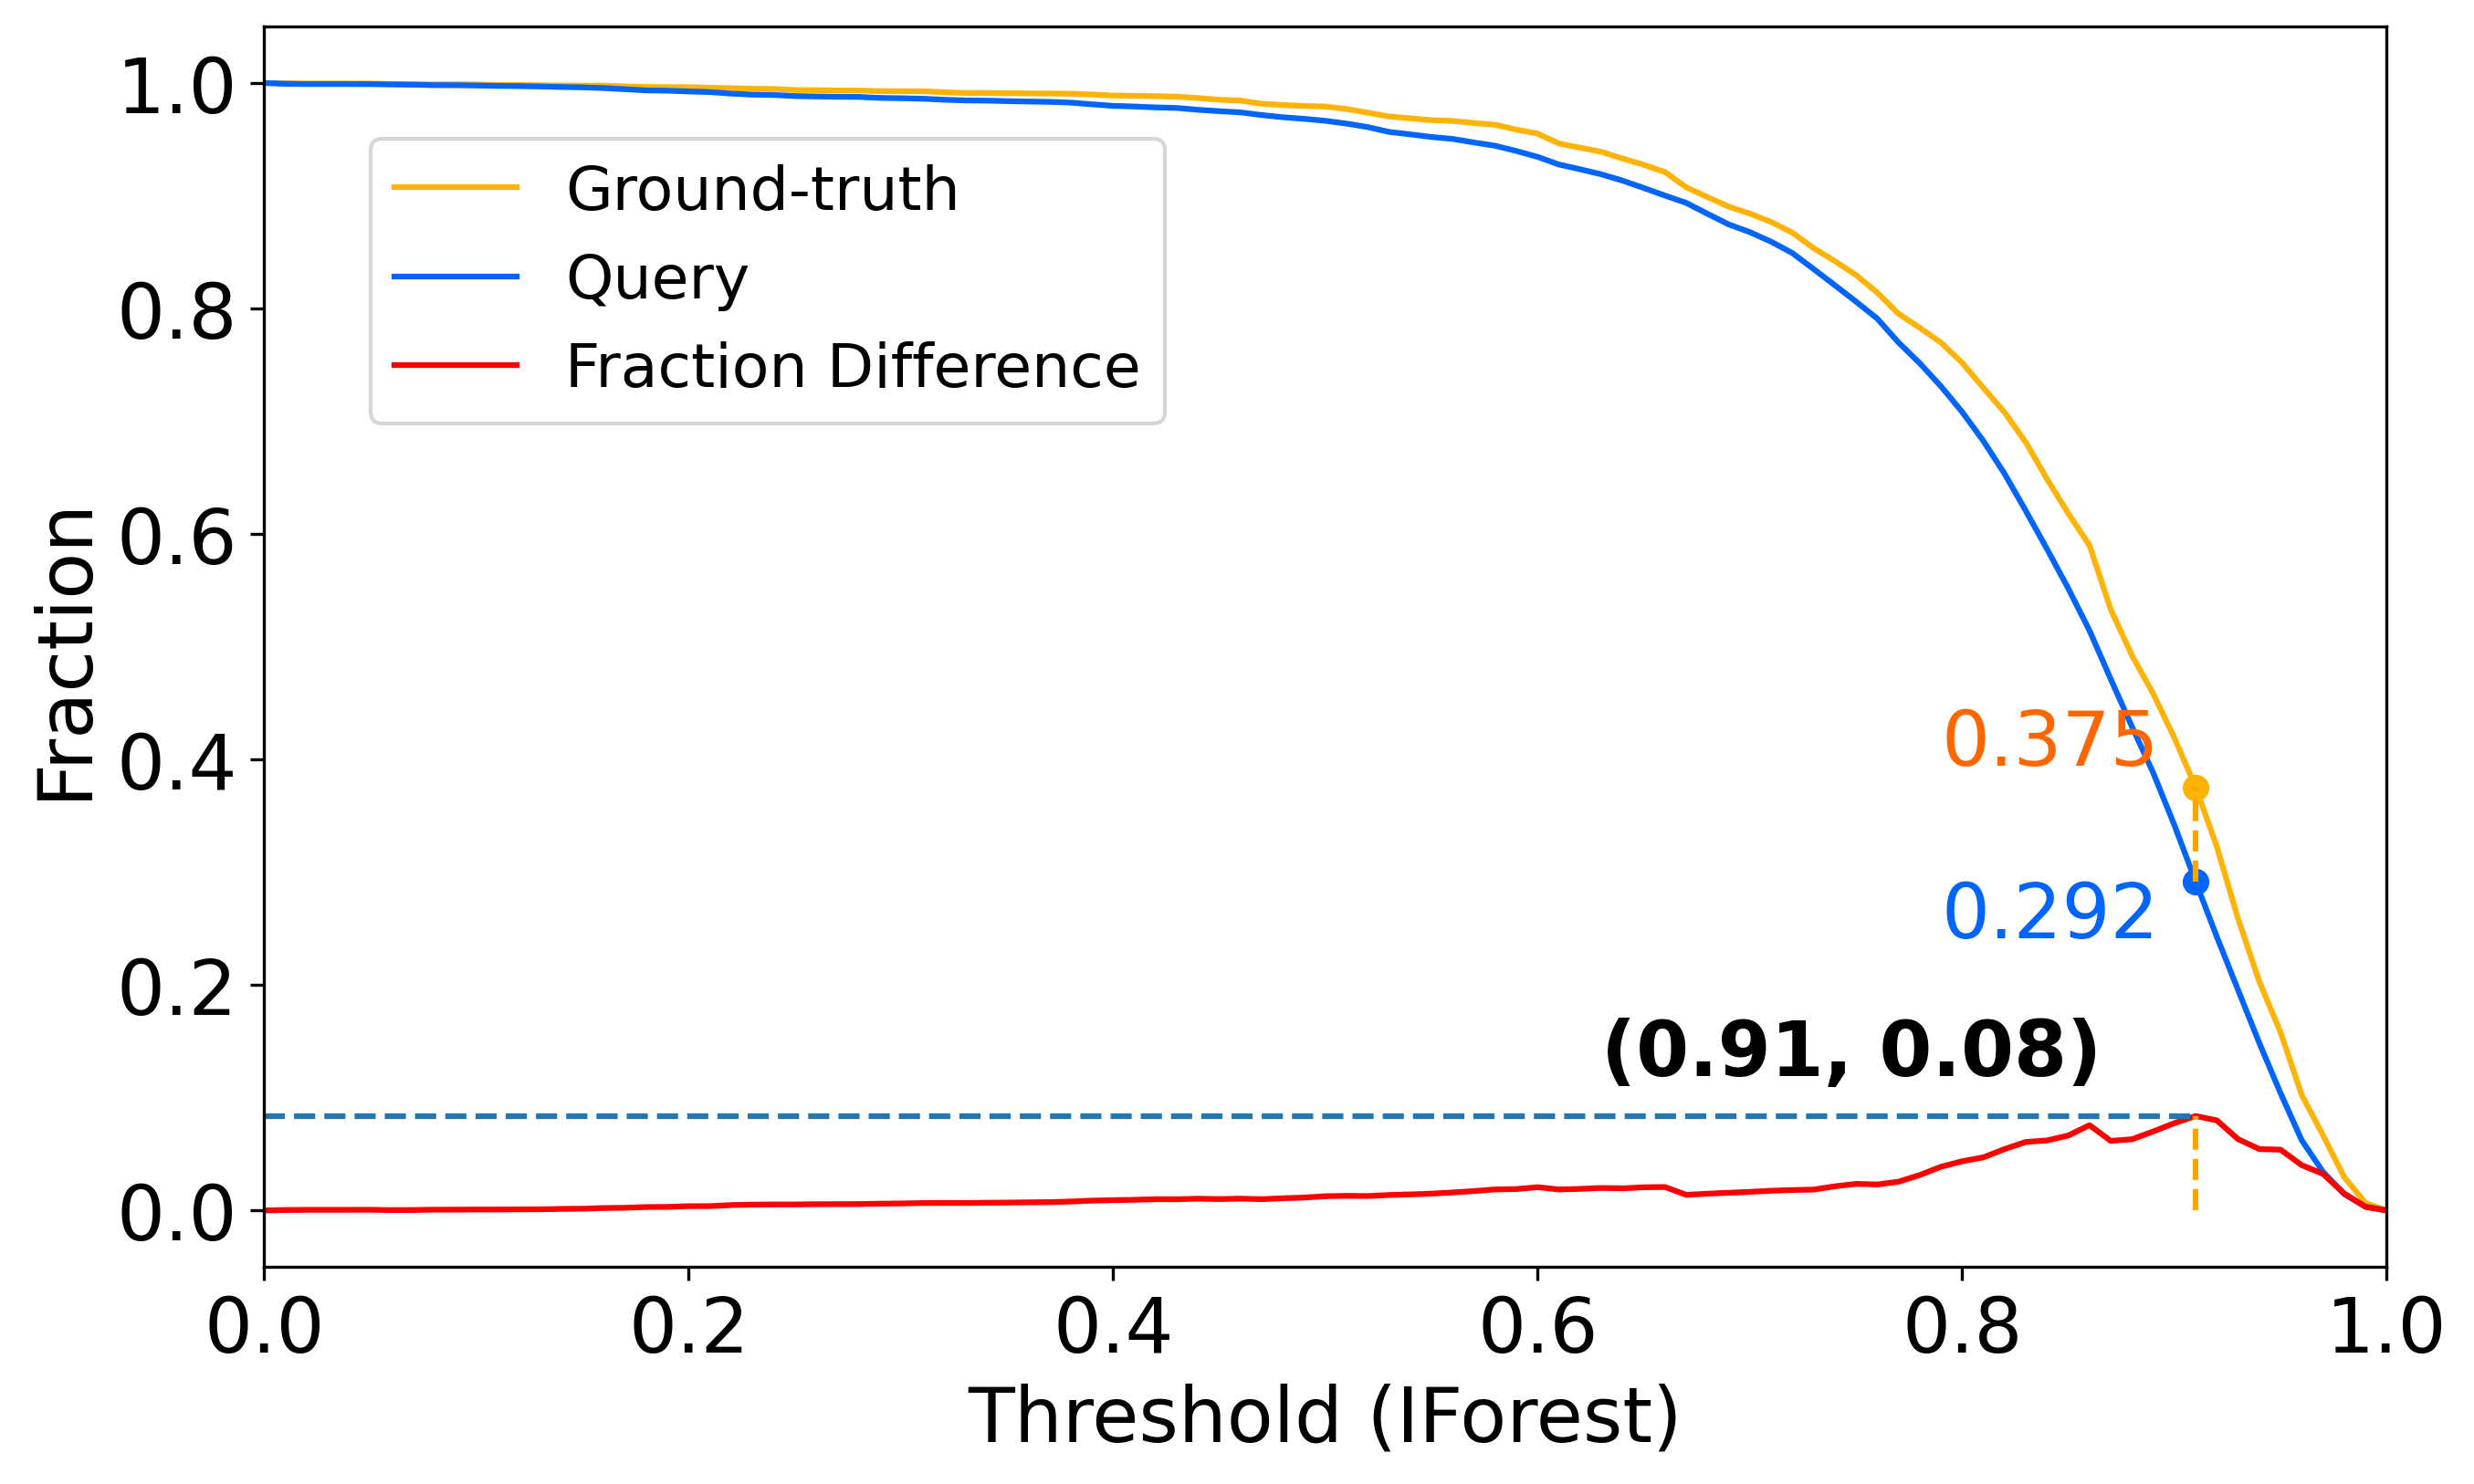

In [9]:
#plot positive fraction distributions
fontsize = 20

%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,6),dpi=300)

#set 100 thresholds between [0,1] 
iter_num = np.linspace(0.0,1.0,num=101)
train_fraction = []
test_fraction = []
single_eval = []

for i in iter_num:
    threshold = i
    train_count_inlier = np.sum(train_scores >= threshold)
    test_count_inlier = np.sum(test_scores[:] >= threshold)
    train_percent = train_count_inlier/7375
    test_percent = test_count_inlier/160582
    single = train_percent - test_percent
    train_fraction.append(train_percent)
    test_fraction.append(test_percent)
    single_eval.append(single)

#plot positive fraction distributions for the ground_truth and the query dataset, and the fraction difference between these two datasets
plt.plot(iter_num,train_fraction,color='#feb308',label='Ground-truth')
plt.plot(iter_num,test_fraction,color='#0165fc',label='Query')
plt.plot(iter_num,single_eval,color='red',label='Fraction Difference')

#extreme point calculation and labelling
single_max = max(single_eval)
temp = single_eval.index(single_max)
threshold_max = iter_num[temp]
plt.plot([0,threshold_max],[single_max,single_max], '--')
plt.plot([threshold_max,threshold_max],[0,single_max], '--', color='orange')
single_max = round(single_max,2)
cord =  '('+str(threshold_max)+', '+format(single_max,'.2f')+')'
plt.text(threshold_max-0.28, single_max+0.04, cord, fontsize=fontsize, fontweight='semibold')
#the positive fraction for the query dataset at the extreme point
test_max = test_fraction[temp]
test_max = round(test_max,3)
plt.scatter(threshold_max, test_max, c='#0165fc')
plt.text(threshold_max-0.12, test_max-0.05, test_max, fontsize=fontsize,c='#0165fc')
#the positive fraction for the ground_truth dataset at the extreme point
train_max = train_fraction[temp]
train_max = round(train_max,3)
plt.scatter(threshold_max, train_max, c='#feb308')
plt.text(threshold_max-0.12, train_max+0.02, train_max, fontsize=fontsize,c='#ff6600')
#draw reference line
refer_min, refer_max = min(train_max, test_max), max(train_max, test_max)
plt.plot([threshold_max,threshold_max],[refer_min,refer_max], '--', color='orange')

label = 'Threshold (IForest)'
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(label, fontsize=fontsize)
plt.ylabel('Fraction', fontsize=fontsize)
plt.legend(prop={'size': 16}, loc=[0.05, 0.68])
plt.xlim(0, 1.0)
    
plt.show()

# positive validation dataset creation and model validation

In [6]:
#import the ground_truth dataset and the query dataset
labelled_pairs = pd.read_csv('../dataset_generation_and_featurization/ground_truth_pairs.csv', index_col=0)
unlabelled_pairs = pd.read_csv('../dataset_generation_and_featurization/query_pairs.csv', index_col=0)

from joblib import dump, load

def fit_predict(clf, X_train, X_val, X_test):
    
    threshold = 0
    train_scores = []
    test_scores = []
    contamination = 0.1
    clf.fit(X_train)

    train_scores = clf.decision_function(X_train) # higher score means outliers
    test_scores = clf.decision_function(X_test)
    val_scores = clf.decision_function(X_val)
    train_scores = train_scores *(-1)  # higher score means inliers
    test_scores = test_scores *(-1)
    val_scores = val_scores *(-1)
    train_pred = clf.predict(X_train)  # 0-inliers; 1-outliers
    test_pred  = clf.predict(X_test)
    threshold = clf.threshold_ *(-1)
    
    return train_scores, test_scores, val_scores, threshold

In [8]:
#import features
metal_minmax = pd.read_csv('dataset/metal_scaled_6.csv',index_col=0)
linker_minmax = pd.read_csv('dataset/linker_scaled_1613.csv',index_col=0)

#remove all 0 feature columns, remain 1460-dimentional feature vector
linker_minmax = linker_minmax.loc[:,(linker_minmax!=0).any(axis=0)]

#generate full data vector
#ground_truth
metal_data= list()
for metal in labelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(labelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in labelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(labelled_pairs['metal'])), columns= linker_minmax.columns.values)
labelled_df = pd.concat([labelled_pairs, metal_data, linker_data], axis = 1)

#query
metal_data= list()
for metal in unlabelled_pairs['metal']:
    metal_data.append(metal_minmax.loc[metal,:])    
metal_data = pd.DataFrame(metal_data, index=np.arange(len(unlabelled_pairs['metal'])), columns = metal_minmax.columns.values)
linker_data= list()
for linker in unlabelled_pairs['linker_SMILES']:   
    linker_data.append(linker_minmax.loc[linker,:])
linker_data = pd.DataFrame(linker_data, index=np.arange(len(unlabelled_pairs['metal'])), columns= linker_minmax.columns.values)
unlabelled_df = pd.concat([unlabelled_pairs, metal_data, linker_data], axis = 1)

from sklearn.model_selection import train_test_split
from pyod.models.iforest import IForest

#training data, validation data, and test data assignment
X = labelled_df.iloc[:,2:] 
X_test = unlabelled_df.iloc[:,2:]
X_train, X_val = train_test_split(X, test_size=0.2, random_state=None)

train_result = pd.DataFrame()
test_result = pd.DataFrame()
val_result = pd.DataFrame() 

#train model
clf_iforest = IForest(behaviour="new", bootstrap=False, contamination=0.1, n_estimators=350,  max_features=1.0, max_samples=1000, random_state=None)
train_scores, test_scores, val_scores, threshold = fit_predict(clf_iforest, X_train, X_val, X_test)

#save scores without normalisation
train_result.insert(train_result.shape[1],column=str('0'),value=train_scores)
test_result.insert(test_result.shape[1],column=str('0'),value=test_scores)
val_result.insert(val_result.shape[1],column=str('0'),value=val_scores)

In [11]:
#save results
train_result.to_csv('poor_train.csv')
test_result.to_csv('poor_test.csv')
val_result.to_csv('poor_val.csv')

In [4]:
#import the result of using only 80% of the ground_truth data to train the model and the remain 20% as a positive validation dataset.
train_result = pd.read_csv('poor_train.csv', index_col=0)
test_result = pd.read_csv('poor_test.csv', index_col=0)
val_result = pd.read_csv('poor_val.csv', index_col=0)

In [11]:
MinMax_scaler = preprocessing.MinMaxScaler()

#score normalisation
scores_range = np.concatenate((train_result.iloc[:,0],val_result.iloc[:,0],test_result.iloc[:,0])).reshape(-1,1)
scores_scaler = MinMax_scaler.fit(scores_range)
train_scores = scores_scaler.transform(np.array(train_result.iloc[:,0]).reshape(-1,1)) 
test_scores = scores_scaler.transform(np.array(test_result.iloc[:,0]).reshape(-1,1))
val_scores = scores_scaler.transform(np.array(val_result.iloc[:,0]).reshape(-1,1))

#a function to calculate the Maximum Fractional Difference (MFD) and the Optimal Threshold (OT) value
def mfd_ot(train_scores, test_scores):
    
    iter_num = np.linspace(0.0,1.0,num=101)
    train_fraction = []
    test_fraction = []
    single_eval = []

    for i in iter_num:
        threshold = i
        train_count_inlier = np.sum(train_scores >= threshold)
        test_count_inlier = np.sum(test_scores[:] >= threshold)
        train_percent = train_count_inlier/len(train_scores)
        test_percent = test_count_inlier/160582
        single = train_percent - test_percent
        train_fraction.append(train_percent)
        test_fraction.append(test_percent)
        single_eval.append(single)

    #extreme point
    single_max = max(single_eval)
    temp = single_eval.index(single_max)
    threshold_max = iter_num[temp]
    
    return threshold_max, single_max

#OT(optimal threshold) and MFD(maximum fractional difference) values calculation
ot, mfd = mfd_ot(train_scores, test_scores)
print(ot, mfd)

0.91 0.06317997099111305


In [12]:
#the positive rate for three datasets calculation under the optimal threshold
train_positive_rate = np.sum(train_scores>=ot)/len(train_scores)
print('np.sum(train_scores>=ot): ', np.sum(train_scores>=ot))
print('len(train_scores): ',len(train_scores))

val_positive_rate = np.sum(val_scores>=ot)/len(val_scores)
print('np.sum(val_scores>=ot): ', np.sum(val_scores>=ot))
print('len(val_scores): ',len(val_scores))

test_positive_rate = np.sum(test_scores>=ot)/len(test_scores)
print('np.sum(test_scores>=ot): ', np.sum(test_scores>=ot))
print('len(test_scores): ',len(test_scores))

print('train_positive_rate: ',train_positive_rate)
print('val_positive_rate: ', val_positive_rate)
print('test_positive_rate: ', test_positive_rate)

np.sum(train_scores>=ot):  2520
len(train_scores):  5900
np.sum(val_scores>=ot):  617
len(val_scores):  1475
np.sum(test_scores>=ot):  58442
len(test_scores):  160582
train_positive_rate:  0.4271186440677966
val_positive_rate:  0.4183050847457627
test_positive_rate:  0.36393867307668354


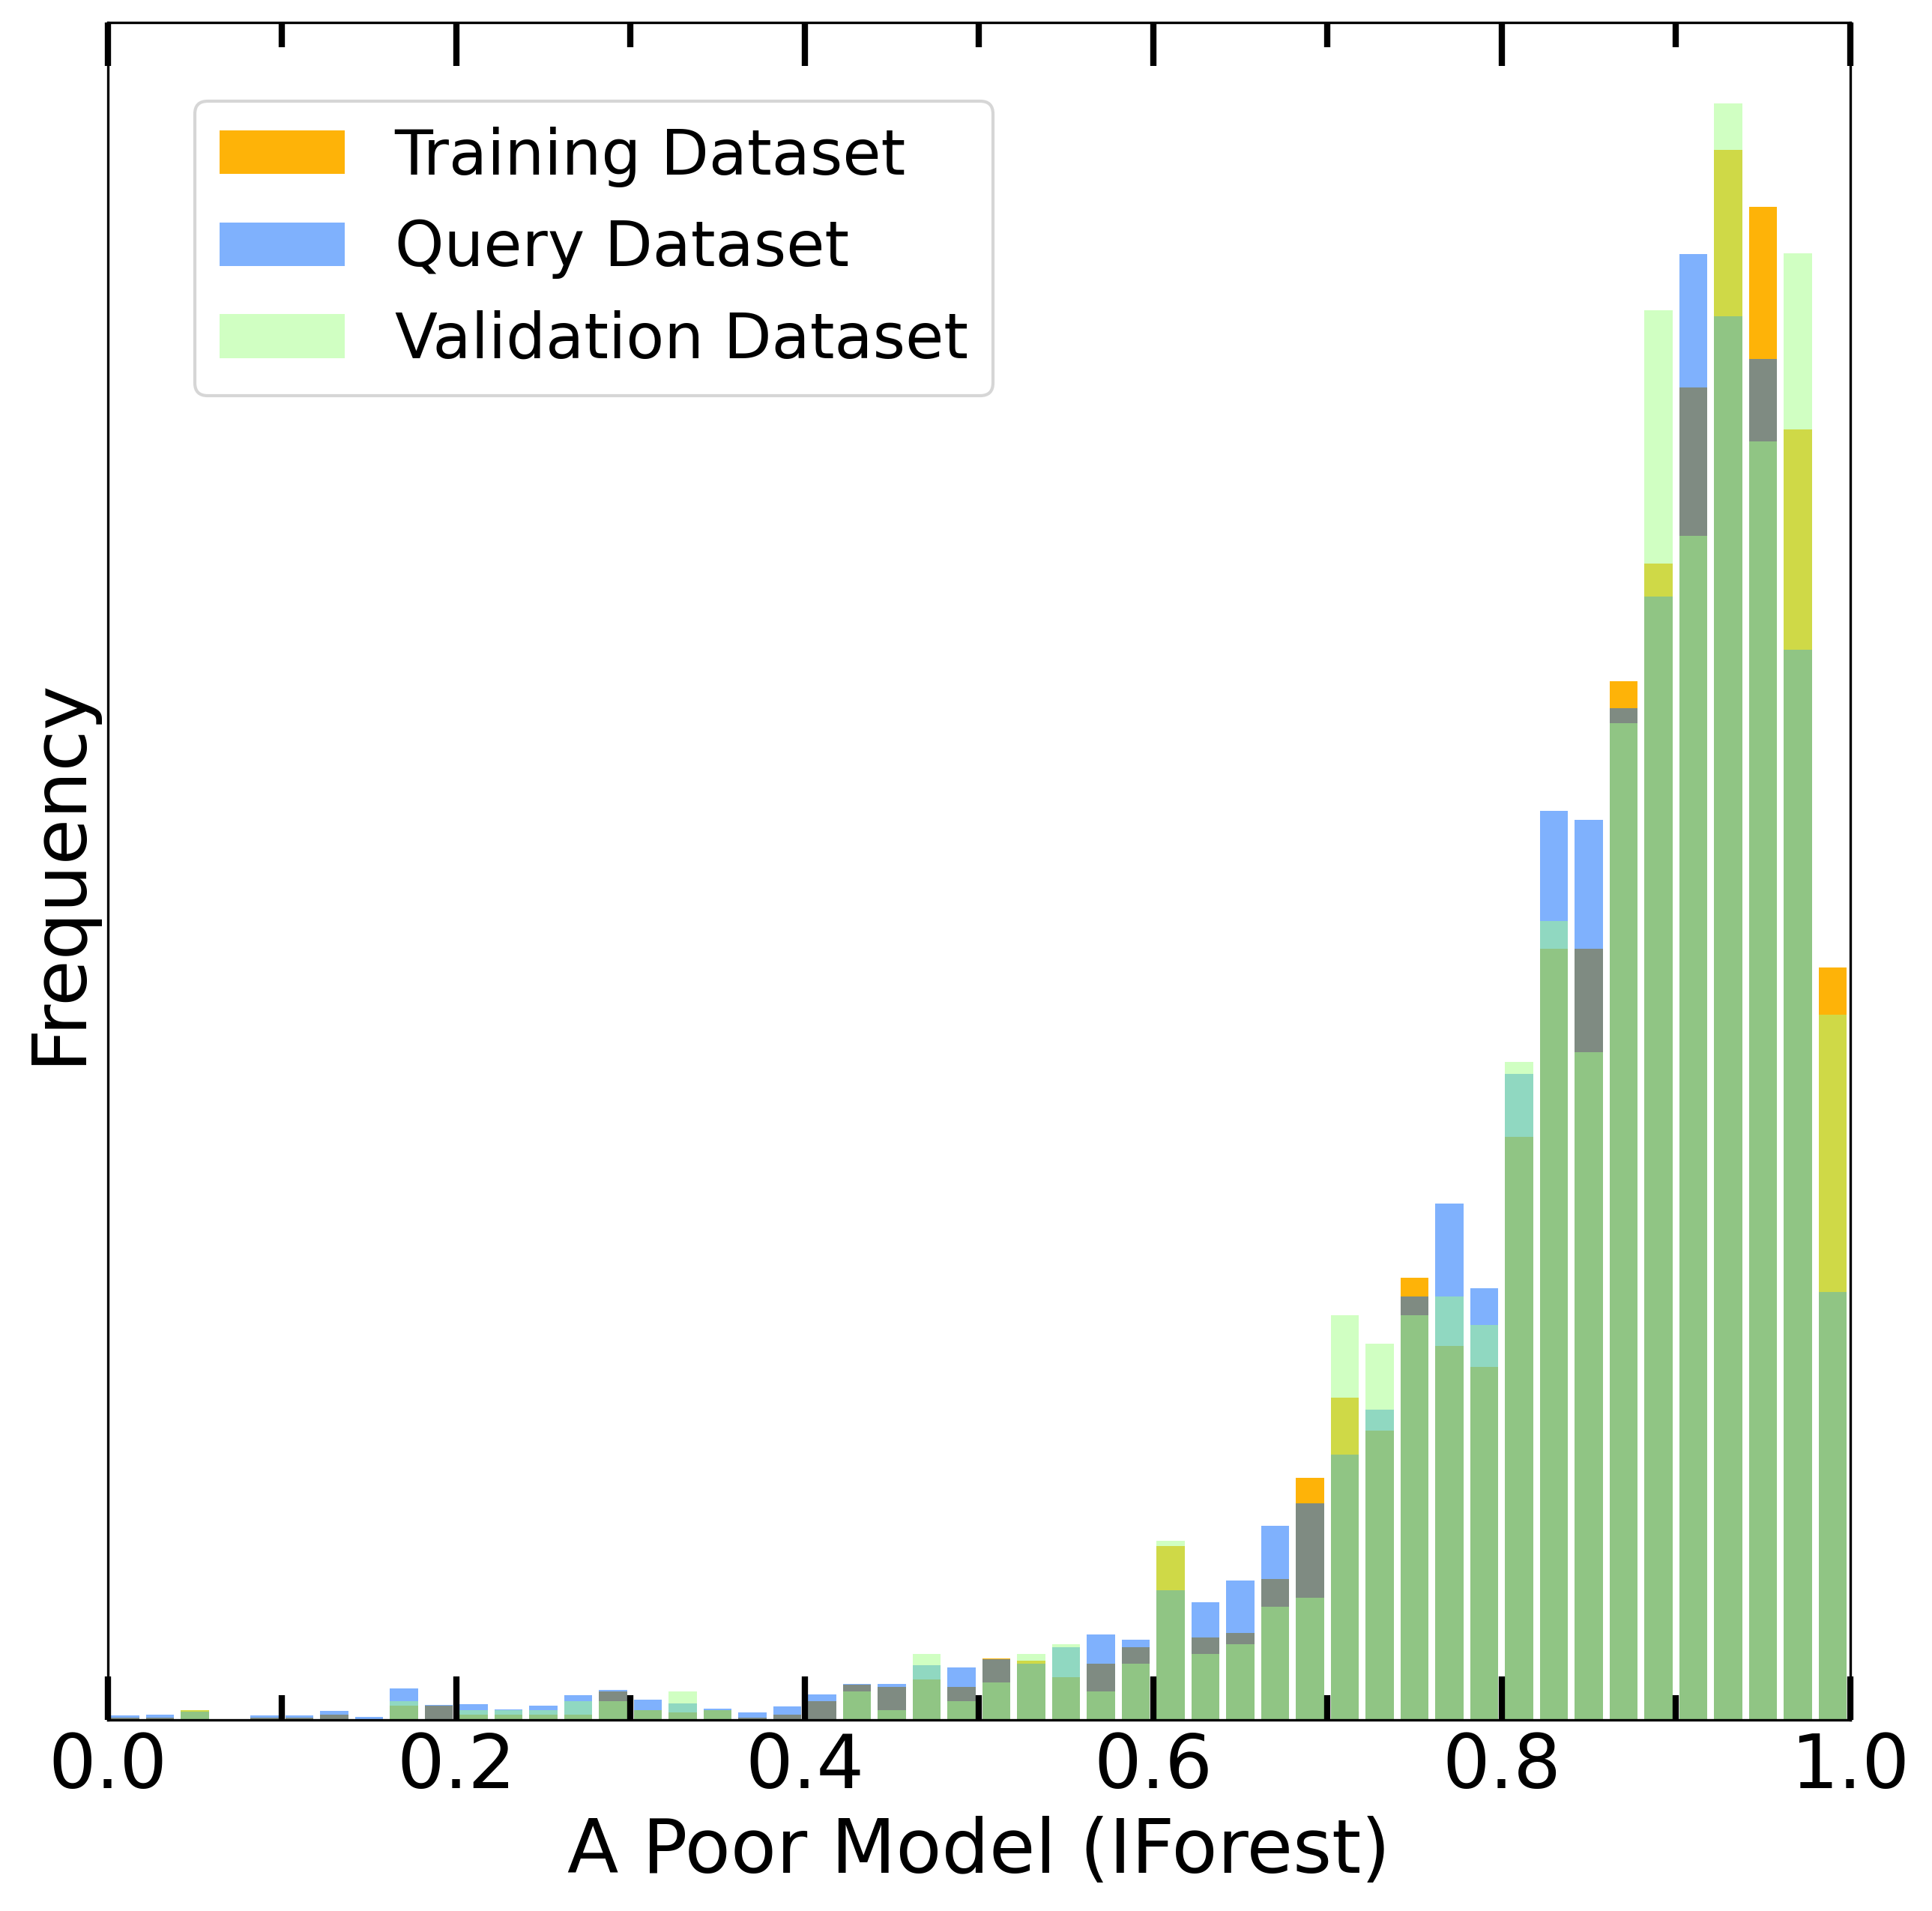

In [13]:
MinMax_scaler = preprocessing.MinMaxScaler()

#plot score distributions
%matplotlib inline
from matplotlib.pyplot import figure
plt.figure(figsize=(10,10),dpi=300)

scores_bins = scores_scaler.transform(scores_range)

ax = plt.subplot(1,1,1)
_, bins , _ = plt.hist(scores_bins, bins=50, density=True, rwidth=0, alpha=0)
plt.hist(train_scores, bins=bins, rwidth=0.8, histtype='bar', density=True, alpha=1, color='#feb308', label='Training Dataset')
_= plt.hist(test_scores[:], bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#0165fc', label='Query Dataset') 
plt.hist(val_scores, bins=bins, density=True, rwidth=0.8, alpha=0.5, color='#A2FF86', label='Validation Dataset')

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('A Poor Model (IForest)', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks([])
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)

plt.legend(prop={'size': 20}, loc=[0.05, 0.78])
   
plt.subplots_adjust(wspace=0.1)
plt.show()  